In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import ipywidgets as widgets
import hublib.ui as ui
mpl.rc('animation', html='jshtml')

<IPython.core.display.Javascript object>

# 1D Heat Transfer in a Copper Bar

A thin copper bar of thickness $L=5\,\mathrm{mm}$ is heated by an electric current resulting in a volumetric heat generation rate of $\dot{q}=5\cdot10^5\,\mathrm{W/m^3}$. The copper bar is in contact with a heat sink at temperature $T_0=50^\circ$C on the lower surface. The upper surface is exposed to an ambient temperature of $T_\infty=20^\circ\mathrm{C}$ with a convection heat transfer coefficient of $h=50\,\mathrm{W/(m^2K)}$. The thermophysical properties of pure copper are $k=$, $c_p=$, $\rho=$.

Let us collect the known values in variables:

In [2]:
rho = 8993
cp = 385
k = 401
h = 50
L = 5e-3
T0 = 50
Tinf = 20
q = 5e5

## 1D Heat Equation in Cartesian Coordinates

The heat transfer in the copper bar is described by the 1D heat equation

\begin{equation}
\rho c_p \frac{\partial T}{\partial t} = k \frac{\partial^2 T}{\partial x^2} + \dot{q} .
\end{equation}

Before we introduce the finite-difference formulation, we are going to obtain the steady-state temperature profile in the copper bar.

### Steady-state solution

The steady-state temperature profile is the solution of the ordinary differential equation
\begin{equation}
k \frac{d^2 T}{d x^2} + \dot{q} .
\end{equation}
subject to the boundary conditions. The general solution $T(x)$ is given by the superposition of the homogeneous solution $T_h(x)=C_1x+C_2$ and the particular solution $T_p(x) = -\frac{\dot{q}}{2k} x^2$, i.e.,
\begin{equation}
T(x) = -\frac{\dot{q}}{2k} x^2 + C_1 x + C_2 .
\end{equation}
The heat flux in the copper bar is given by Fourier's law
\begin{equation}
q''(x) = -k \frac{dT}{dx} = \dot{q} x - k C_1 .
\end{equation}
We choose the coordinate system such that the surface in contact with the heat sink is located at $x=0$ and the surface exposed to ambient air is located at $x=L$. The boundary conditions are then $T(0)=T_0$ and $q''(L)=h(T(L)-T_\infty)$ (Newton's law of cooling). We thus have to solve the equation system
\begin{align}
T(0) &= T_0 = C_2 \\
q''(L) &= h\left[T(L)-T_\infty\right] = h \left[ -\frac{\dot{q}}{2k} L^2 + C_1 L + C_2 -T_\infty \right] = \dot{q} L - k C_1 ,
\end{align}
which leads to

\begin{align}
C_1 &= \frac{\frac{\dot{q}h}{2k}L^2+\dot{q}L-h(T_0-T_\infty)}{k+hL} \\
C_2 &= T_0 .
\end{align}
Let us plot this solution:

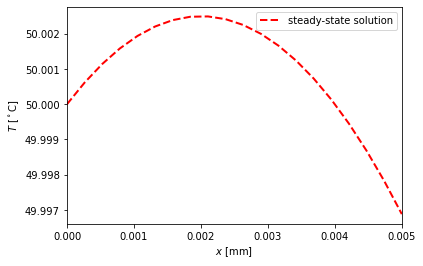

In [3]:
def steady_state(x):
    C2 = T0
    C1 = (q*L+h*q/(2*k)*L**2-h*(C2-Tinf))/(k+h*L)
    T = -q/(2*k)*x**2 + C1*x + C2
    return T

xs = np.linspace(0,L,20)
plt.plot(xs,steady_state(xs),'r--',lw=2,label='steady-state solution')
plt.xlabel(r'$x\ \mathrm{[mm]}$')
plt.ylabel(r'$T\ \mathrm{[^\circ C]}$')
plt.xlim(0,L)
plt.ticklabel_format(useOffset=False)
plt.legend()
plt.show()

### Finite Difference Formulation

The transient solution requires to solve the partial differential equation, and we have not yet discussed how to do that analytically. Here, we are going to look at a numerical solution. The basic idea is to replace the derivates with respect to space and time by finite differences. We can obtain the finite difference expression by using a Taylor expansion:

To estimate the second spatial derivative the temperature $T$, we expand the temperature at $T(x+\Delta x)$ and $T(x-\Delta x)$ around $T(x)$
\begin{equation}
\begin{split}
T(x+\Delta x) &= T(x) + \Delta x \frac{\partial T}{\partial x} + \frac{(\Delta x)^2}{2} \frac{\partial^2 T}{\partial x^2} + \dots \\
T(x-\Delta x) &= T(x) - \Delta x \frac{\partial T}{\partial x} + \frac{(\Delta x)^2}{2} \frac{\partial^2 T}{\partial x^2} - \dots
\end{split}
\end{equation}
By subtracting the two equations, we obtain an approximate expression for the first derivative
\begin{equation}
\frac{\partial T}{\partial x} \approx \frac{T(x+\Delta x)-T(x-\Delta x)}{2\Delta x}
\end{equation}
By summing the two equations, we obtain an approximate expression for the second derivative
\begin{equation}
\frac{\partial^2 T}{\partial x^2} \approx \frac{T(x+\Delta x) - 2 T(x) + T(x-\Delta x)}{(\Delta x)^2} .
\end{equation}
The time derivative of $T$ can be approximated by a so called _forward Euler time step_
\begin{equation}
T(t+\Delta t) = T(t) + \Delta t \frac{\partial T}{\partial t}
\end{equation}

We now plug the finite differences into the original PDE to obtain an algebraic integration scheme for the transient heat equation:
\begin{equation}
T(x,t+\Delta t) = T(x,t) + \Delta t \frac{k}{\rho c_p} \left( \frac{T(x+\Delta x,t) - 2 T(x,t) + T(x-\Delta x,t)}{(\Delta x)^2} + \frac{\dot{q}}{k} \right)
\end{equation}

### Discretization

This equation gives an update rule for a set of discrete points on the $x$ axis, evenly spaced by a distance $\Delta x$. Successive applications of the update rule yield the solution at discrete time steps with increment $\Delta t$. It is worth noting that the forward Euler step is conditionaly stable. This means that the time step $\Delta t$ needs to be sufficiently small such that $\alpha \Delta t/(\Delta x)^2<0.5$. Let us introduce the discrete points and space and time steps, assuming that want to integrate until `time`.

In [4]:
time = 0.25

dx = 2.5e-4
dt = 1.0e-4

xs = np.arange(0,L+dx,dx)
ts = np.arange(0,time+dt,dt)

### Boundary conditions

Looking at the update scheme, we see that the new value for each point depends on its two neighbors. However, at the boundaries of the domain, only one neighbor exists and it seems at first that the update rule cannot be applied. This can be resolved by considering the boundary conditions.

The boundary conditions for the copper bar are
\begin{equation}
\begin{split}
T(0,t) &= T_o  \\
- k \left. \frac{\partial T}{\partial x}\right|_{x=L} &= h \left[ T(L,t) - T_\infty \right]
\end{split}
\end{equation}

Thus, at the lower boundary condition we can simply set the temperature to the fixed value $T_o$. The convection boundary condition can be approximated by
\begin{equation}
-k \frac{T(L+\Delta x) -T(L-\Delta x)}{2\Delta x} = h \left[ T(L,t) - T_\infty \right] ,
\end{equation}
which can be written as 
\begin{equation}
T(L+\Delta x) = T(L-\Delta x) - 2\Delta x\frac{h}{k} \left[ T(L,t) - T_\infty \right] .
%T(L,t) = \left( 1 + \Delta x \frac{h}{k} \right)^{-1} \left[T(L-\Delta x,t) + \Delta x \frac{h}{k} T_\infty \right]  .
\end{equation}

Therefore, the Euler step at this boundary becomes
\begin{equation}
T(L,t+\Delta t) %= T(L,t) + \Delta t \frac{k}{\rho c_p} \left( \frac{T(L+\Delta x,t) - 2 T(L,t) + T(L-\Delta x,t)}{(\Delta x)^2} + \frac{\dot{q}}{k} \right) \\
= T(L,t) + \Delta t \frac{k}{\rho c_p} \left( \frac{ 2 T(L-\Delta x) - 2 T(L,t) - 2\Delta x\frac{h}{k}\left[ T(L,t)-T_\infty\right]}{(\Delta x)^2} + \frac{\dot{q}}{k} \right) .
\end{equation}

To facilitate modifying the boundary conditions later, let us define them as functions:

In [5]:
def left_boundary(T):
    return T0 # Dirichlet boundary condition

def right_boundary(T):
    return T[-1] + dt*k/(rho*cp)*(2*(T[-2]-T[-1]-dx*h/k*(T[-1]-Tinf))/dx**2+q/k) # Neumann boundary condition

We can now define a function that computes the transient solution:

In [6]:
def transient():
    steps = len(ts)-1
    Ts = np.zeros((len(ts),len(xs)))
    Ts[0] = [T0]*len(xs) # initial condition
    T = np.copy(Ts[0])
    for t in range(len(ts)-1):
        T[0] = left_boundary(T)
        T[-1] = right_boundary(T)
        T[1:-1] += dt*k/(rho*cp) * ( (T[2:] - 2*T[1:-1] + T[:-2]) / (dx**2) + q/k ) # forward Euler step
        Ts[t+1] = T
    return Ts

Let us plot the solution at selected times along with the steady-state solution:

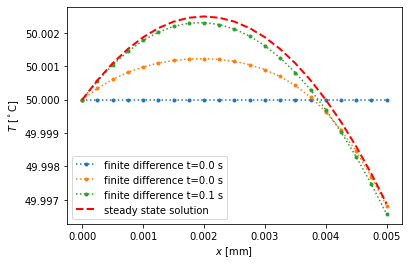

In [7]:
Ts = transient()
for t in [0,100,1000]:
    plt.plot(xs,Ts[t],'.:',label='finite difference t=%.1f'%ts[t]+' s')
plt.plot(xs,steady_state(xs),'r--',lw=2,label='steady state solution')
plt.xlabel(r'$x\ \mathrm{[mm]}$')
plt.ylabel(r'$T\ \mathrm{[^\circ C]}$')
plt.ticklabel_format(useOffset=False)
plt.legend()
plt.show()

### Effect of materials properties on the steady and transient solution

One observation we can make is that the temperature difference within the copper bar is rather small. To see the effects of the parameters a little better, we are going to change the setup of the problem a little. Instead of a constant temperature at the left boundary, we will now consider the left surface of the copper bar to be insulated, i.e., $q''(0)=0$. This will of course change the steady-state solution.

#### Exercise: Obtain the integration constants $C_1$ and $C_2$ for this new setup.

In [8]:
def left_boundary(T):
    T = T[0] + dt*k/(rho*cp)*(2*(T[1]-T[0])/dx**2+q/k)
    return T

def steady_state(x):
    C2 = Tinf + q*L/h + q/(2*k)*L**2
    C1 = 0
    T = -q/(2*k)*x**2 + C1*x + C2
    return T

In the widget below, you can explore the effect of the materials properties on the steady-state solution and the transient behavior. _Note that it takes some time to update the animation every time you change a value._

In [9]:
def animate1d(T,frames=100,interval=50):
    step = len(T)//frames
    T = np.vstack([T[0],T[1::step]])

    def init():
        profile.set_data(xs,T[0])
        time_text.set_text('t={0:.4f} s'.format(0))
        bifo_text.set_text(r'$\tau$'+'={0:.1e}\nBi={1:.1e}\nFo={2:.1e}'.format(tau,Bi,0))
        return (profile,time_text,bifo_text)

    def animate(i):
        Fo = k/(rho*cp)*i*dt*step/L**2
        profile.set_data(xs,T[i])
        time_text.set_text('t={0:.4f} s'.format(i*dt*step))
        bifo_text.set_text(r'$\tau$'+'={0:.1e}\nBi={1:.1e}\nFo={2:.1e}'.format(tau,Bi,Fo))
        return (profile,time_text,bifo_text)

    tau = rho*cp*L/h
    Bi = h*L/k
    Fo = k/(rho*cp)*t/L**2
    Tst = steady_state(xs)
    Tmax = max(80,np.max(steady_state(xs)))
    Tmin = min(Tinf,np.min(steady_state(xs)))

    fig, ax = plt.subplots()
    ax.plot(xs,Tst,'r--',lw=2,label='steady-state solution')
    profile, = ax.plot(xs,Ts[0],'r',label='transient solution')
    ax.set_ylim(Tmin-(Tmax-Tmin)/10,Tmax+(Tmax-Tmin)/10)
    ax.ticklabel_format(useOffset=False)
    ax.set_title('Temperature Profile')
    ax.set_xlabel('x')
    ax.set_ylabel('T')
    ax.legend(loc=3)
    time_text = ax.text(0.7, 0.9, 't=0 s', transform=ax.transAxes, color='k', fontsize=14)
    bifo_text = ax.text(0.7, 0.5,r'$\tau$'+'={0:.1e}\nBi={1:.2f}\nFo={2:.2f}'.format(tau,Bi,Fo), transform=ax.transAxes, fontsize=14)
    
    ani = mpl.animation.FuncAnimation(fig, animate, init_func=init,
                                  frames=len(T), interval=interval, blit=True)
    plt.close()
    return ani

In [10]:
def animate_transient(name='', value=''):
    global time, ts, k, cp, h, q
    
    # set parameters
    time = t_widget.value # observation time
    k = k_widget.value # thermal conductivity
    cp = cp_widget.value # heat capacity
    h = h_widget.value # convection coefficient
    q = q_widget.value # heat generation
    ts = np.arange(0,time+dt,dt)
    Ts = transient()
    
    ani = animate1d(Ts,frames=40,interval=100)
    with out_widget:
        out_widget.clear_output(wait=True)
        display(ani)
    return ani

t_widget = ui.Number(
    name = 'time',
    desc = 'total observation time',
    value = 0.5,
    cb = animate_transient
)
dt_widget = ui.Number(
    name = 'dt',
    desc = 'time step',
    value = 2.5e-4,
    cb = animate_transient
)
q_widget = ui.Number(
    name = 'q',
    desc = 'heat generation',
    value = 5e5,
    cb = animate_transient
)
k_widget = ui.Number(
    name = 'k',
    desc = 'thermal conductivity',
    value = 401,
    cb = animate_transient
)
cp_widget = ui.Number(
    name = 'cp',
    desc = 'specific heat capacity',
    value = 385,
    cb = animate_transient
)
h_widget = ui.Number(
    name = 'h',
    desc = 'convection coefficient',
    value = 20,
    cb = animate_transient
)

out_widget = widgets.Output(layout=widgets.Layout())

display(ui.Form([out_widget,t_widget,dt_widget,k_widget,cp_widget,h_widget,q_widget]))
ani = animate_transient() # this call ensures that the animation is shown in the widget

Group(children=(Output(), Number(children=(HTML(value='<div data-toggle="popover" title="total observation tim…

The widget above displays two important dimensionless numbers, the Biot number $Bi$ and the Fourier number $Fo$. They are defined as
\begin{align}
Bi &= \frac{hL}{k} \\
Fo &= \frac{\alpha t}{L^2} ,
\end{align}
where $\alpha=\frac{k}{\rho c_p}$ is the _thermal diffusivity_. You can observe how $Bi$ varies with the materials properties. Note that $Fo$ increases with time - in fact, it can be considered a dimensionless time. Later in the course, we will learn how these dimensionless numbers can be used to obtain useful approximations for transient heat transfer solutions.

## Exercises

1. Obtain the steady-state temperature profile in the copper bar.
2. Implement the forward Euler finite difference scheme discussed in class. For the given parameters, a resolution $\Delta x=2.5\cdot10^{-4}\ \mathrm{mm}$ and a time step $\Delta t=10^{-4}\ \mathrm{s}$ will yield a stable scheme. Plot the solution at three different times in _one axis system_ to demonstrate that it converges to the steady-state solution. Plot the steady-state solution in the _same axis system_ as well. _Hint:_ The transient profile should be close to the steady-state solution after $\approx 1\ \mathrm{s}$. 
3. What do you expect when the heat generation is set to zero? Check if your Matlab code produces the expected behavior.
4. Switch the heat generation back on and assume that the surface at $x=0$ is now insulated. Copy your Matlab code into a new script and update it to the new boundary condition. Plot the solution at three different times and also the steady-state solution in _one axis system_. _Hint:_ The time it takes to approach the steady-state solution will be much longer. Observe the solution at least up to $100\ \mathrm{s}$. The insulating boundary condition at $x=0$ can be formulated as
\begin{equation*}
T(0,t+1) = T(0,t) + \frac{2k}{\rho c_p} \frac{\Delta t}{\Delta x^2} \left[ T(1,t)-T(0,t) \right] + \frac{\dot{q}}{\rho c_p} \Delta t
\end{equation*}
5. Reduce the thermal conductivity to $k=0.4\ \mathrm{W/(m\cdot K)}$. What do you observe? Plot the solution at three different times and the steady-state solution in _one axis system_.
6. Switch off the heat generation again. What is the new steady-state solution? What do you observe? Plot the solution at three different times and the steady-state solution in _one axis system_.
7. Increase the convection coefficient to $h=5000\ \mathrm{W/(m^2\cdot K)}$. What do you observe? Plot the solution at three different times and the steady-state solution in _one axis system_.
8. Summarize your findings.
    
    1. What is the effect of the thermal conductivity on the shape of the temperature profile?
    2. What is the effect of the convection coefficient on the shape of the temperature profile?
    3. What is the effect of the thermal conductivity on the time it takes to reach the steady-state solution?
    4. What is the effect of the convection coefficient on the time it takes to reach the steady-state solution?

The general behavior of the transient solution can be characterized by the Biot number $Bi=\frac{hL}{k}$ and the thermal time constant $\tau=\frac{\rho c_p L}{h}$. Based on these quantities:

1. Formulate a hypothesis how the thickness $L$ of the copper bar will affect the temperature profile and the time it takes to reach the steady-state solution.
2. Formulate a hypothesis how the thermal heat capacity $\rho c_p$ of the copper bar will affect the temperature profile and the time it takes to reach the steady-state solution.